In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

Let's explore the dataset.

In [3]:
print(df.shape)
print(df.columns)

(299, 13)
Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')


We have 299 samples, 12 features and 1 output to predict.
Let's look at how the data is represented.

In [4]:
print(df.head())

    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

The output as well as 5 features are categorical, the rest are numerical.
Let's check the balance between +ve and -ve samples

In [5]:
num_positive = df["DEATH_EVENT"].value_counts()[1]
num_negative = df["DEATH_EVENT"].value_counts()[0]
percentage_pos = (num_positive / df.shape[0]) * 100
percentage_neg = (num_negative / df.shape[0]) * 100

print(f'Positive samples: {num_positive}')
print(f'Negative samples: {num_negative}')
print(f'Percentage Positive samples: {percentage_pos:.3f}%')
print(f'Percentage Negative samples: {percentage_neg:.3f}%')

Positive samples: 96
Negative samples: 203
Percentage Positive samples: 32.107%
Percentage Negative samples: 67.893%


The samples are somewhat balanced.
Let's check if there are any missing values


In [6]:
print(df.isna().sum())

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


No missing values.
Let's now look at the correlations between features and the output.

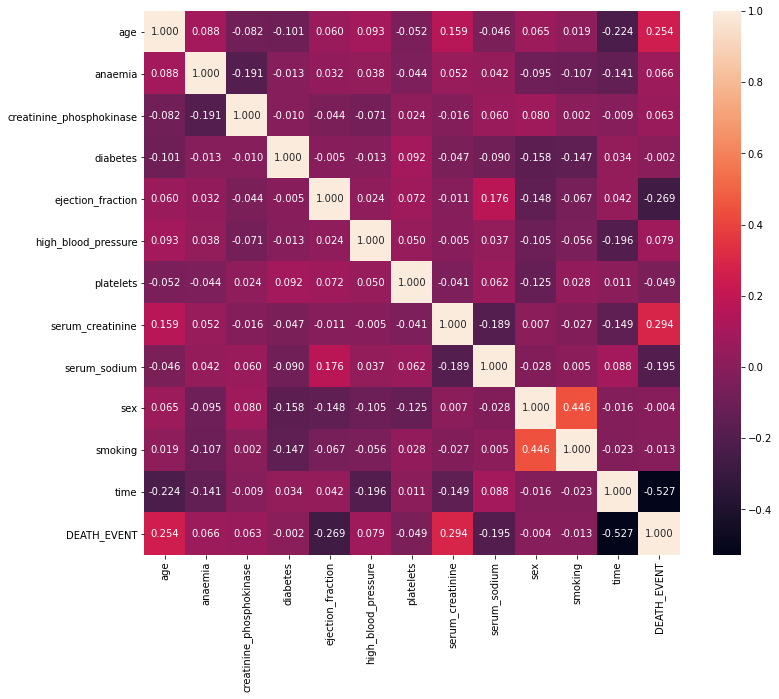

In [7]:
correlation_matrix = df.corr()
plt.subplots(figsize=(12,10))
corr_max_plot = sns.heatmap(correlation_matrix, annot=True, fmt=".3f")

It seems like 'sex' and 'diabetes' are features highly uncorrelated with the output. So we will drop them as this can impact the generalization performance of some classifiers.

In [8]:
df_removed_uncorr = df.drop(['diabetes', 'sex'], axis=1)

In [9]:
X = df_removed_uncorr.drop(['DEATH_EVENT'], axis=1)

In [10]:
y = df_removed_uncorr['DEATH_EVENT']

In [11]:
print(X.shape)
print(y.shape)

(299, 10)
(299,)


Split the dataset between train and validation set with a ratio 80%/20%

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
print(X_train.shape)

(239, 10)


Investigate the proportion of positive and negative samples in train set.

In [14]:
num_positive = sum(y_train)
num_negative = y_train.shape[0] - num_positive
percentage_pos = (num_positive / y_train.shape[0]) * 100
percentage_neg = (num_negative / y_train.shape[0]) * 100

print(f'Positive samples: {num_positive}')
print(f'Negative samples: {num_negative}')
print(f'Percentage Positive samples: {percentage_pos:.3f}%')
print(f'Percentage Negative samples: {percentage_neg:.3f}%')

Positive samples: 71
Negative samples: 168
Percentage Positive samples: 29.707%
Percentage Negative samples: 70.293%


We need to normalize numerical features and one hot encode categorical features, such that they all lie in a similar range of values. This will be encoded in a pipeline followed by our Ensemble Classifier, such that similar preprocessing is applied to future test inputs.

In [15]:
standard_scaler = StandardScaler() 
one_hot = OneHotEncoder(handle_unknown='ignore')
numerical_features = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "time"]
categorical_features = ["anaemia", "high_blood_pressure", "smoking"]

transformer = ColumnTransformer(transformers=[("one_hot", one_hot, categorical_features),
                                 ("scaling", standard_scaler, numerical_features)], remainder="passthrough")

Let's now train different models to create an ensemble model. We choose models which are known to behave quite well even when used alone (which is not the case for single Decision Trees which can overfit quite easily for example). We also avoid models already using ensemble methods, like Random Forests and Gradient Boosting.

In [27]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [28]:
ensemble_classifier = VotingClassifier(estimators=[ 
    ('SVC', SVC()),
    ('LogisticR', LogisticRegression()),
    ('RandomF', RandomForestClassifier())
    ], voting='hard')

params = {'SVC__C': [0.1, 1., 10.],
          'SVC__kernel': ['linear', 'rbf'],
      'LogisticR__C': [0.1, 1., 10.],
         'RandomF__n_estimators': [20, 50, 100],
         'RandomF__max_features' : [2,4,6,8]}

ensemble_gridsearch = GridSearchCV(estimator=ensemble_classifier, param_grid=params, cv=5)


In [29]:
pipe = Pipeline([('transformer', transformer), ('ensemble_gridsearch', ensemble_gridsearch)])
pipe.fit(X_train, y_train)

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33645\anaconda3\envs\sensyne_project\li

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['anaemia',
                                                   'high_blood_pressure',
                                                   'smoking']),
                                                 ('scaling', StandardScaler(),
                                                  ['age',
                                                   'creatinine_phosphokinase',
                                                   'ejection_fraction',
                                                   'platelets',
                                                   'serum_creatinine',
                                                   'serum_sodium', 'time'])])),
                ('ensemble_gridsearch',
              

Let's inspect what were the best hyperparameters found with GridSearch

In [30]:
print(pipe[1].best_params_)

{'LogisticR__C': 10.0, 'LogisticR__solver': 'newton-cg', 'RandomF__max_features': 4, 'RandomF__n_estimators': 50, 'SVC__C': 0.1, 'SVC__kernel': 'rbf'}


In [31]:
print("model score on train set: %.3f" % pipe.score(X_train, y_train))
print("model score on test set: %.3f" % pipe.score(X_test, y_test))

model score on train set: 0.904
model score on test set: 0.783


In [25]:
import pickle

In [26]:
pickle_out = open("ensemble_classifier.pkl", "wb")
pickle.dump(pipe, pickle_out)
pickle_out.close()